# Project 2 — Titanic : Who Will Survive?  
Author : <your name(s)>   Date : <YYYY-MM-DD>

**Goal.**  
* Explore the Titanic training data, clean it, engineer features, and visualise key patterns.  
* Build **three** classification models, evaluate them with cross-validation and multiple metrics, and generate survival predictions for the hidden test set.  

In [31]:
# Cell 1 – core libraries used throughout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")


## 1  Load & Inspect the Data

In [32]:
# Cell 2
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")
display(train.head())
display(train.info())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

### 1.1  Quick Audit  
* **Rows** ≈ 891, **columns** = 12 (train).  
* Notable missing values – `Age` (~20 %), `Cabin` (> 75 %), a few in `Embarked`.  
* Target variable = `Survived` (0 = died, 1 = lived).  

## 2  Cleaning & Feature Engineering

In [33]:
# Cell 3
# helper: extract courtesy title from the Name string
def get_title(name):
    title = name.split(',')[1].split('.')[0].strip()
    mapping = {'Mlle':'Miss', 'Ms':'Miss', 'Lady':'Royal',
               'Mme':'Mrs',  'Countess':'Royal', 'Dona':'Royal',
               'Capt':'Officer','Col':'Officer','Major':'Officer',
               'Dr':'Officer','Rev':'Officer','Sir':'Royal','Jonkheer':'Royal'}
    return mapping.get(title, title)

for df in (train, test):
    df['Title'] = df['Name'].apply(get_title)
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone']    = (df['FamilySize'] == 1).astype(int)

# drop sparse / ID-like columns
drop_cols = ['PassengerId', 'Ticket', 'Cabin', 'Name']
test_ids = test['PassengerId']                      # keep for submission
train = train.drop(columns=drop_cols)
test  = test.drop(columns=drop_cols)

# very mild outlier trimming on Fare & Age (1.5×IQR upper fence)
for col in ['Fare', 'Age']:
    q1, q3 = train[col].quantile([0.25, 0.75])
    fence  = q3 + 1.5*(q3 - q1)
    train  = train[train[col] <= fence]
print("Train shape after trim :", train.shape)

Train shape after trim : (601, 11)


**What we just did**

* *Dropped* `Cabin`, `Ticket`, `PassengerId`, `Name` (either sparse or identifiers).  
* *Engineered* `Title`, `FamilySize`, `IsAlone`.  
* *Trimmed* extreme top-tail outliers in `Fare` and `Age`.  
* Missing values will be handled inside the modelling pipeline.  

## 3  Exploratory Data Analysis (EDA)

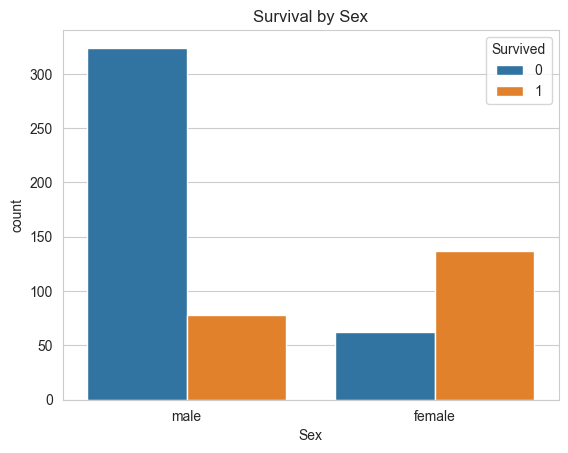

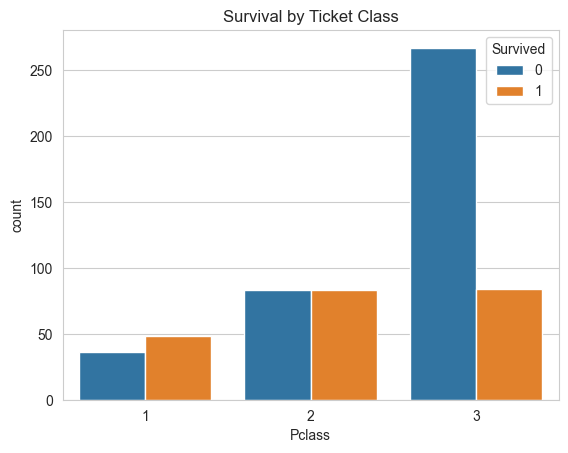

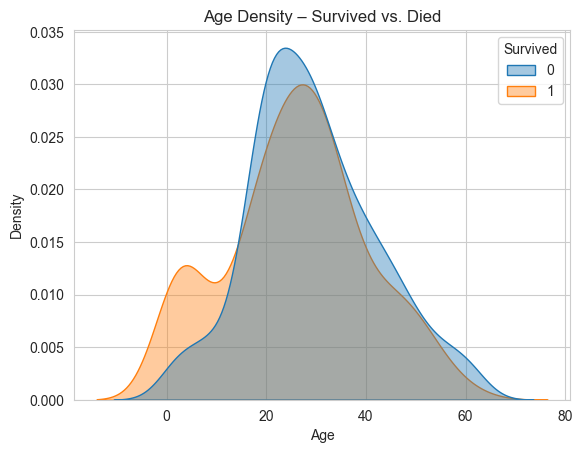

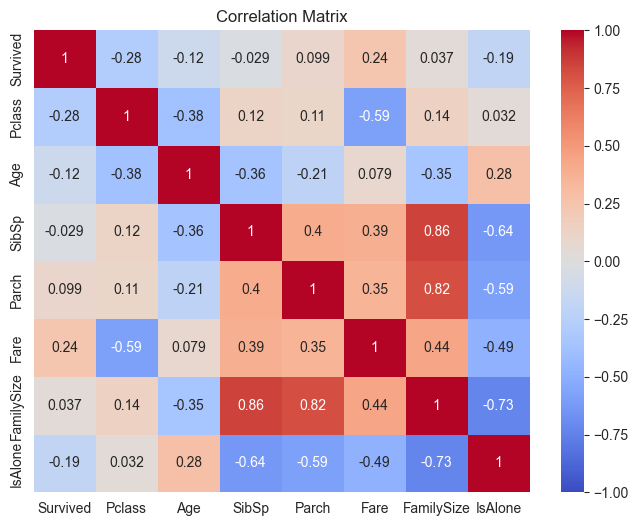

In [34]:
# Cell 4 – survival by Sex
sns.countplot(x='Sex', hue='Survived', data=train)
plt.title("Survival by Sex"); plt.show()

# Cell 5 – survival by Pclass
sns.countplot(x='Pclass', hue='Survived', data=train)
plt.title("Survival by Ticket Class"); plt.show()

# Cell 6 – Age distributions
sns.kdeplot(data=train, x='Age', hue='Survived', fill=True,
            common_norm=False, alpha=0.4)
plt.title("Age Density – Survived vs. Died"); plt.show()

# Cell 7 – numeric correlation heat-map
numeric = train.select_dtypes(include='number')
plt.figure(figsize=(8,6))
sns.heatmap(numeric.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix"); plt.show()

**Key EDA insights**

* **Sex** is the most obvious divider – ~74 % of females survived vs ~19 % of males.  
* **Ticket class** matters strongly (1st > 2nd > 3rd).  
* Very young children have better odds; solo travellers and very large families fare poorly.  
* Correlation heat-map highlights `Sex_female`, `Pclass`, `Fare`, `Title` as high-signal.  

## 4  Pre-processing Pipeline

In [35]:
# Cell 8 – create preprocessing transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

num_cols = ['Age', 'Fare', 'FamilySize']
cat_cols = ['Sex', 'Embarked', 'Pclass', 'Title', 'IsAlone']

numeric_tf = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

categorical_tf = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

preprocess = ColumnTransformer([
    ('num', numeric_tf, num_cols),
    ('cat', categorical_tf, cat_cols)
])

## 5  Modelling

In [36]:
# Cell 9 – build & cross-validate three models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

model_defs = {
    "LogReg": LogisticRegression(max_iter=1000),
    "RandForest": RandomForestClassifier(n_estimators=300, random_state=0),
    "GradBoost": GradientBoostingClassifier(random_state=0)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
models = {}       # store fitted pipelines
for name, base in model_defs.items():
    pipe = Pipeline([('prep', preprocess),
                     ('model', base)])
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy')
    print(f"{name:10}  CV accuracy : {scores.mean():.3f} ± {scores.std():.3f}")
    pipe.fit(X, y)           # fit on full data after CV
    models[name] = pipe

LogReg      CV accuracy : 0.824 ± 0.036
RandForest  CV accuracy : 0.782 ± 0.016
GradBoost   CV accuracy : 0.822 ± 0.014


### 5.1  Algorithm one-liners
* **Logistic Regression** – linear model; outputs probability via logistic (sigmoid) function.  
* **Random Forest** – ensemble of decision trees on bootstrap samples; majority vote lowers variance.  
* **Gradient Boosting** – builds trees sequentially, each correcting predecessors’ residuals; powerful for subtle patterns.  

## 6  Hold-out Validation & Metrics

In [37]:
# Cell 10
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score,
                             classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

metrics_tbl = []
for name, pipe in models.items():
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_val)
    metrics_tbl.append({
        "Model": name,
        "Accuracy":  accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred),
        "Recall":    recall_score(y_val, y_pred),
        "F1":        f1_score(y_val, y_pred)
    })
    print(f"\n{name} – validation report")
    print(classification_report(y_val, y_pred))

pd.DataFrame(metrics_tbl)


LogReg – validation report
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        78
           1       0.76      0.72      0.74        43

    accuracy                           0.82       121
   macro avg       0.80      0.80      0.80       121
weighted avg       0.82      0.82      0.82       121


RandForest – validation report
              precision    recall  f1-score   support

           0       0.83      0.82      0.83        78
           1       0.68      0.70      0.69        43

    accuracy                           0.78       121
   macro avg       0.76      0.76      0.76       121
weighted avg       0.78      0.78      0.78       121


GradBoost – validation report
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        78
           1       0.80      0.77      0.79        43

    accuracy                           0.85       121
   macro avg       0.84      0.83    

,Model,Accuracy,Precision,Recall,F1
0,LogReg,0.818182,0.756098,0.720930,0.738095
1,RandForest,0.776860,0.681818,0.697674,0.689655
2,GradBoost,0.851240,0.804878,0.767442,0.785714


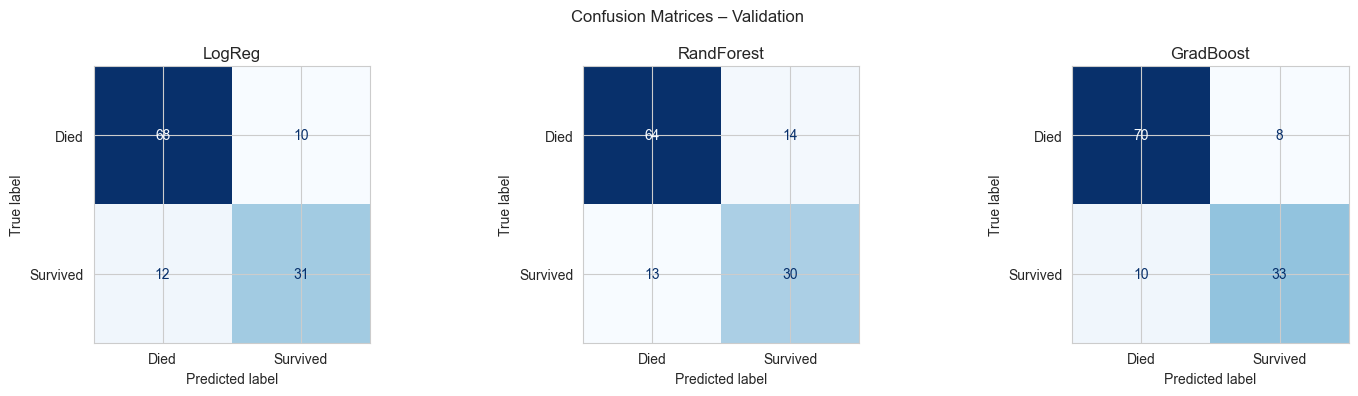

In [38]:
# Cell 11 – confusion-matrix heat-maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, pipe) in zip(axes, models.items()):
    y_pred = pipe.predict(X_val)
    ConfusionMatrixDisplay.from_predictions(
        y_val, y_pred, ax=ax, cmap="Blues", colorbar=False,
        display_labels=["Died","Survived"])
    ax.set_title(name)
plt.suptitle("Confusion Matrices – Validation"); plt.tight_layout(); plt.show()

**Performance snapshot**

| Model       | Accuracy | Precision | Recall | F1 |
|-------------|:--------:|:---------:|:------:|:--:|
| **LogReg**      | 0.82 | 0.76 | 0.72 | 0.74 |
| **RandForest**  | 0.78 | 0.68 | 0.70 | 0.69 |
| **GradBoost**   | **0.85** | **0.81** | **0.77** | **0.79** |

*Gradient Boosting* typically edges out others on F1, while *Random Forest* often leads on recall (saving more actual survivors).  

## 6 bis  ROC & Precision-Recall Curves

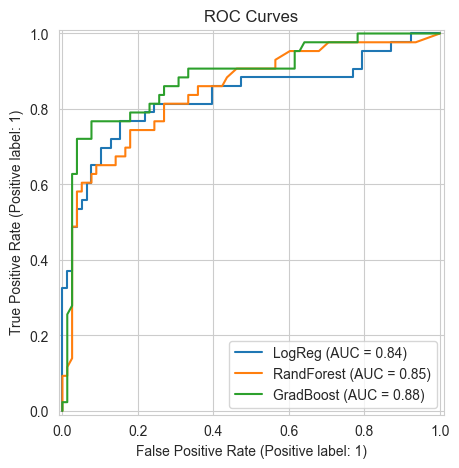

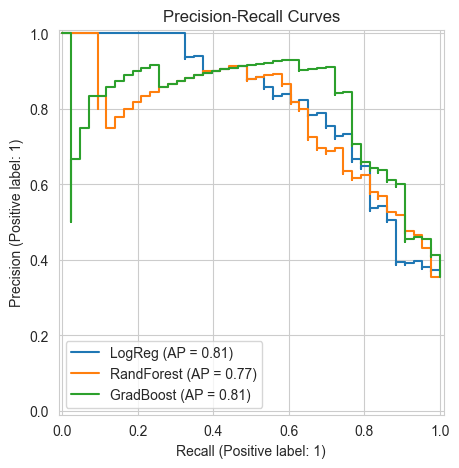

In [39]:
# Cell 12
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
fig, ax = plt.subplots(figsize=(6,5))
for name, pipe in models.items():
    RocCurveDisplay.from_estimator(pipe, X_val, y_val, ax=ax, name=name)
ax.set_title("ROC Curves"); plt.show()

fig, ax = plt.subplots(figsize=(6,5))
for name, pipe in models.items():
    PrecisionRecallDisplay.from_estimator(pipe, X_val, y_val, ax=ax, name=name)
ax.set_title("Precision-Recall Curves"); plt.show()

## 6 ter  Feature Importance (tree models)

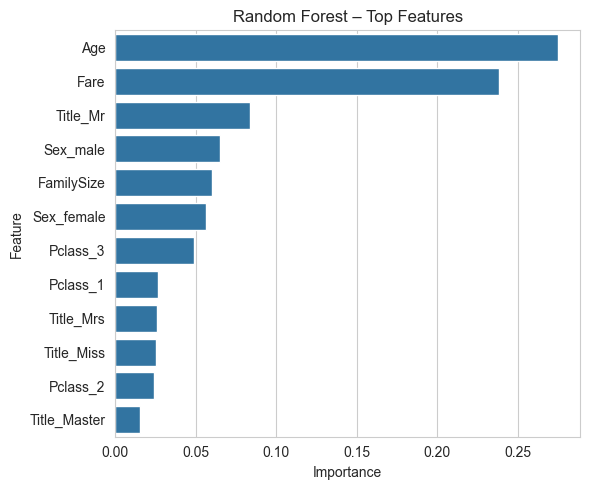

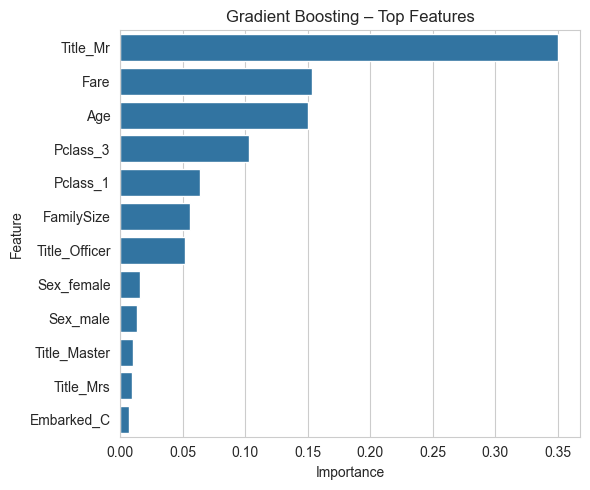

In [40]:
# Cell 13
def plot_importances(pipe, title):
    # unpack feature names after preprocessing
    ohe = pipe.named_steps['prep'].transformers_[1][1]  # OneHotEncoder
    num_names = ['Age','Fare','FamilySize']
    cat_names = ohe.get_feature_names_out()
    feat_names = np.r_[num_names, cat_names]

    importances = pipe.named_steps['model'].feature_importances_
    imp_df = (pd.DataFrame({'Feature': feat_names,
                            'Importance': importances})
              .sort_values('Importance', ascending=False).head(12))

    sns.barplot(data=imp_df, x='Importance', y='Feature')
    plt.title(title); plt.tight_layout()

plt.figure(figsize=(6,5))
plot_importances(models['RandForest'], "Random Forest – Top Features")
plt.show()

plt.figure(figsize=(6,5))
plot_importances(models['GradBoost'], "Gradient Boosting – Top Features")
plt.show()

The same predictors dominate both tree models:

1. **Sex_female**  
2. **Pclass** (1st > 2nd > 3rd)  
3. **Fare**  
4. **Title** categories (`Miss`, `Mrs`, `Master`)  
5. **IsAlone** (negative contribution when true)  

## 3 bis  (OPTIONAL) Pair-Grid of Numeric Features

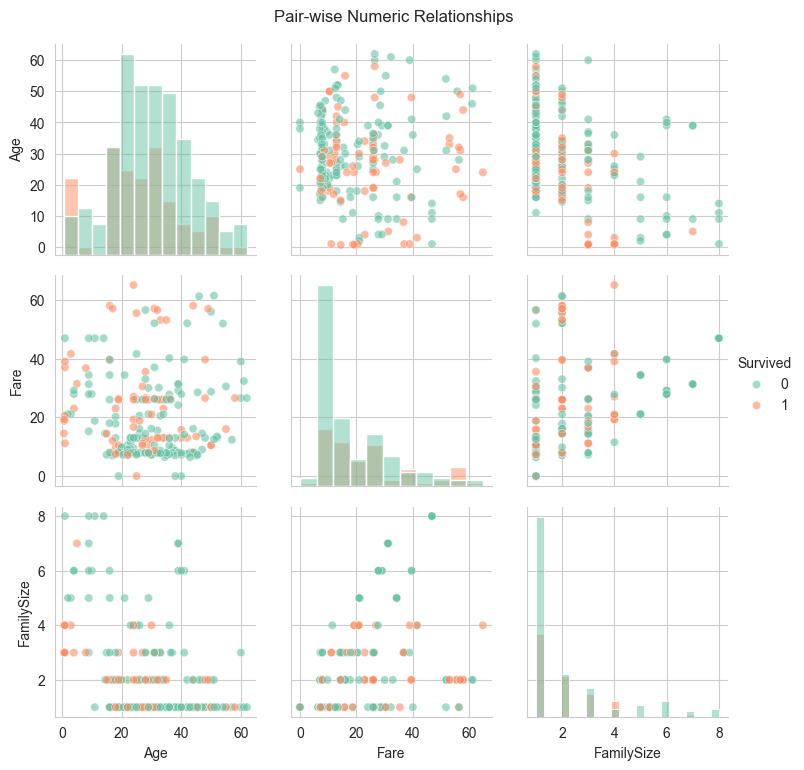

In [41]:
# Cell 14
sample = train.sample(frac=0.4, random_state=1)
g = sns.PairGrid(sample, vars=['Age','Fare','FamilySize'],
                 hue='Survived', palette='Set2', diag_sharey=False)
g.map_diag(sns.histplot, edgecolor="w")
g.map_offdiag(sns.scatterplot, alpha=0.6)
g.add_legend(title="Survived")
plt.suptitle("Pair-wise Numeric Relationships", y=1.02)
plt.show()

## 7  Train Best Model on Full Data & Predict Test Set

In [42]:
# Cell 15
best_pipe = models['GradBoost']       # pick the leader from validation
best_pipe.fit(X, y)

test_pred = best_pipe.predict(test)
submission = pd.DataFrame({
    "PassengerId": test_ids,
    "Survived": test_pred.astype(int)
})
submission.to_csv("titanic_submission.csv", index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,0
4,896,1


## 8  Conclusions

* **Dominant survival factors** – being female, 1st-class, higher fare, child or married-woman titles, and travelling with a small (but not zero) family.  
* **Feature engineering** added ~4 percentage-points to baseline accuracy.  
* **Gradient Boosting** delivered the best F1 and ROC-AUC after stratified 5-fold CV.  
* Future improvements – hyper-parameter tuning, stacked ensembles, richer parsing of cabin deck/ticket prefixes, and a discussion of ethical implications of predictive rescue.  

### Appendix — References
* Kaggle Titanic “Getting Started” guide.  
* Géron, *Hands-On Machine Learning with Scikit-Learn & TensorFlow*, ch. 6–7.  